## Importing the libraries

In [3]:
from numba.core.errors import NumbaDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import folium
import IPython.display

sns.set()

# Analysis of Charging Stations in India

Dataset source: https://www.kaggle.com/datasets/saketpradhan/electric-vehicle-charging-stations-in-india

The columns in the dataset are:
* `name`: The name of the charging station
* `state`: The state where the charging station is located
* `city`: The city where the charging station is located
* `address`: The address of the charging station
* `lattitude`: The latitude of the charging station
* `longitude`: The longitude of the charging station
* `type`: The type of charging station (slow, fast, or ultra-fast)

## Reading the dataset

In [4]:
# Reading the charging dataset
charging_df = pd.read_csv("datasets/ev-charging-stations-india.csv")
charging_df.head()

,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.9803,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.0818,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.2760,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.7218,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.7218,12.0


In [5]:
charging_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1547 non-null   object 
 1   state      1547 non-null   object 
 2   city       1547 non-null   object 
 3   address    1507 non-null   object 
 4   lattitude  1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1539 non-null   float64
dtypes: float64(2), object(5)
memory usage: 84.7+ KB


## Data Preprocessing

### Dropping Duplicate Data

In [6]:
# Drop duplicate values
print(f"Number of duplicate rows: {charging_df.duplicated().sum()}")
charging_df.drop_duplicates(inplace=True)

Number of duplicate rows: 205


### Dropping Missing Data

In [7]:
# Drop missing values
charging_df.dropna(inplace=True)
charging_df.reset_index(drop=True, inplace=True)

### Changing dtype of variables

In [8]:
# Changing the datatype of variables
charging_df["lattitude"] = charging_df["lattitude"].str.replace(',', '').astype(float)
charging_df["type"] = charging_df["type"].astype(int)

### Creating new variable `charging_speed`

In [9]:
# Creating a variable "charging_speed"
def encode_type(type_value):
    if type_value <= 11:
        return "slow"
    elif type_value <= 16:
        return "fast"
    else:
        return "ultra-fast"

charging_df["charging_speed"] = charging_df["type"].apply(encode_type)

### Cleaning the `lattitude` and `longitude` variables

In [10]:
charging_df.describe()

,lattitude,longitude,type
count,1291.000000,1.291000e+03,1291.000000
mean,19.907463,6.599958e+04,8.928737
std,6.932307,2.368613e+06,4.167747
min,8.390198,8.058454e+00,6.000000
25%,13.032111,7.578536e+01,7.000000
50%,19.051601,7.721756e+01,7.000000
75%,27.179942,7.846415e+01,10.000000
max,77.597289,8.510551e+07,24.000000


The maximum value for the `longitude` variable is 85105514 and minimum value is 8.0584541 which could be a mistake. Also the maximum value for the `lattitude` variable is 77.597289. As the longitude of India ranges from approximately 68 to 97, and lattitude ranges from 8 to 37, we will correct these values in the below cells.

In [11]:
# Correcting the maximum and minimum values of the longitude variable
charging_df.iloc[charging_df.longitude.argmax(), 5] = charging_df.iloc[charging_df.longitude.argmax(), 5] / 10e5
charging_df.iloc[charging_df.longitude.argmin(), 5] = charging_df.iloc[charging_df.longitude.argmin(), 5] * 10

In [12]:
index = charging_df.lattitude.argmax()
lat = charging_df.loc[charging_df.lattitude.argmax(), "lattitude"]

# Swap the values of latitude and longitude for row 535
charging_df.loc[index, "lattitude"] = charging_df.loc[index, "longitude"]
charging_df.loc[index, "longitude"] = lat

In [13]:
charging_df.describe()

,lattitude,longitude,type
count,1291.000000,1291.000000,1291.000000
mean,19.857340,77.586028,8.928737
std,6.746304,3.663208,4.167747
min,8.390198,69.678673,6.000000
25%,13.031820,75.794858,7.000000
50%,19.051601,77.217962,7.000000
75%,27.094893,78.466949,10.000000
max,32.991800,94.168072,24.000000


### Correcting the state names

In [14]:
incorrect_state_name = {
    "Uttrakhand": "Uttarakhand",
    "Uttarkhand": "Uttarakhand",
    "Tamilnadu": "Tamil Nadu",
    "Taminadu": "Tamil Nadu",
    "Westbengal": "West Bengal",
    "Hyderabadu00A0": "Hyderabad",
    "Jammu": "Jammu & Kashmir",
    "Andhra pradesh": "Andhra Pradesh",
    "Andra Pradesh": "Andhra Pradesh",
    "Andhrapradesh": "Andhra Pradesh",
    "Rajahmundry": "Andhra Pradesh",
    "Puducherry": "Pondicherry",
    "Bhubhaneswar": "Odisha",
    "Chattisgarh": "Chhattisgarh",
    "Chikhali": "Maharashtra",
    "Maharashra": "Maharashtra",
    "Delhi Ncr": "Delhi",
    "Ernakulam": "Kerala",
    "Karala": "Kerala",
    "Kochi": "Kerala",
    "Hisar": "Haryana",
    "Harayana": "Haryana",
    "Jajpur": "Rajasthan",
    "Limbdi": "Gujarat",
    "Andaman": "Andaman & Nicobar",
}

charging_df["state"] = charging_df["state"].str.strip().str.title()
charging_df["state"] = charging_df["state"].replace(incorrect_state_name)
charging_df["state"] = charging_df["state"].str.strip().str.title()


### Correcting the city names

In [15]:
incorrect_city_name = {
    "Delhi": "New Delhi",
    "Bengaluru": "Bangalore"
}

charging_df["city"] = charging_df["city"].str.strip().str.title()
charging_df["city"] = charging_df["city"].replace(incorrect_city_name)

## EDA

### Top 10 states with maximum charging stations

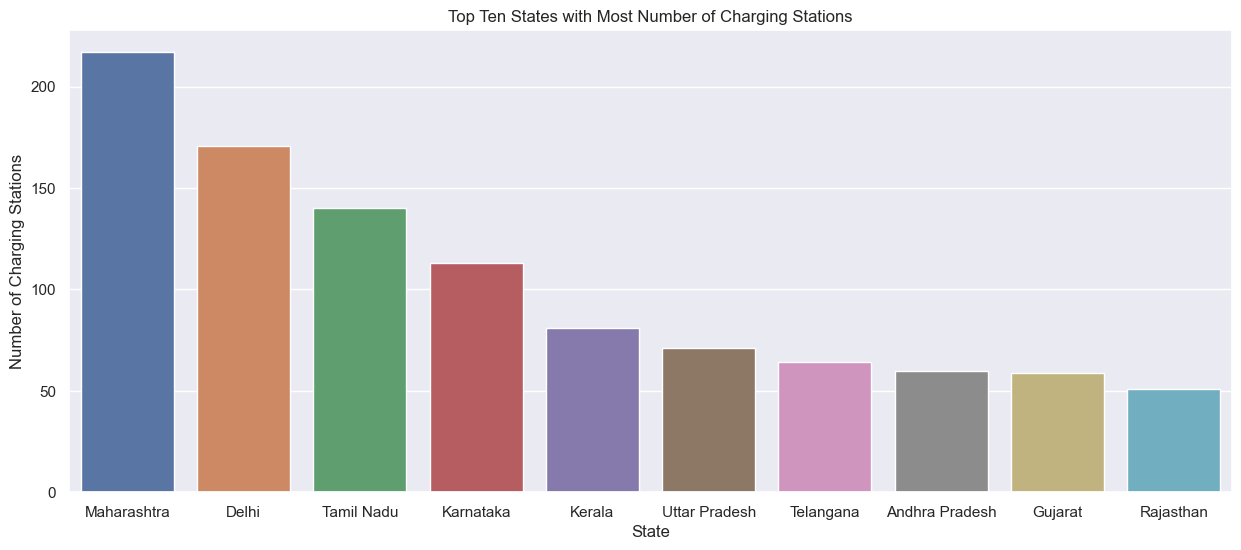

In [16]:
# Get the top ten states with most number of charging stations.
top_ten_states = charging_df["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states["index"], y=top_ten_states["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Most Number of Charging Stations")
plt.xlabel("State")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by state. The state with the most number of charging stations is `Maharashtra`, followed by `Delhi` and `Tamil Nadu`.

### Top 10 cities with maximum charging stations

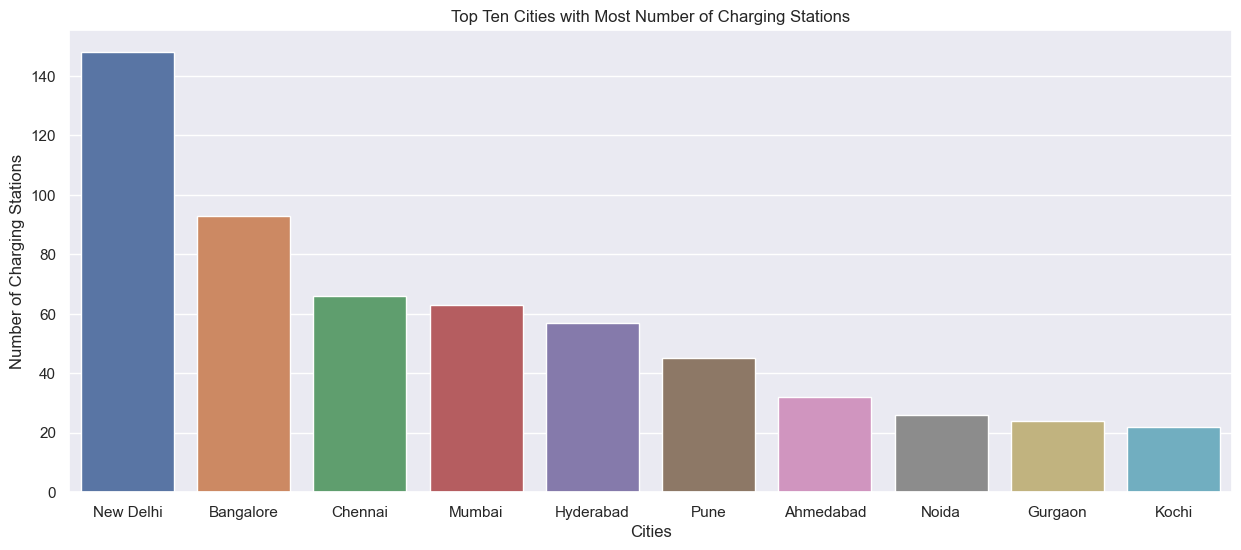

In [17]:
# Get the top ten cities with most number of charging stations.
top_ten_city = charging_df["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_city["index"], y=top_ten_city["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Most Number of Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

The plot shows the distribution of charging stations in India by city. The city with the most number of charging stations is `New Delhi`, followed by `Bangalore` and `Chennai`. We can see that the top 4 cities are metropolitan cities.

### Distribution of different types of charging stations

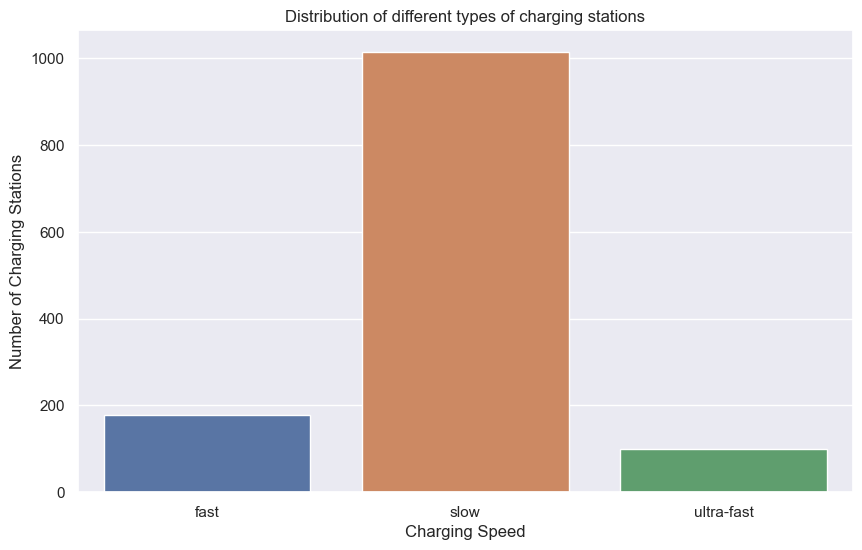

In [18]:
# Create a bar chart.
plt.figure(figsize=(10, 6))
sns.countplot(data=charging_df, x="charging_speed")

# Add a title and labels to the axes.
plt.title("Distribution of different types of charging stations")
plt.xlabel("Charging Speed")
plt.ylabel("Number of Charging Stations");

Most of the charging stations in India provide slow charging for the EV. There are very few ultra-fast charging stations.

### States with fast charging stations

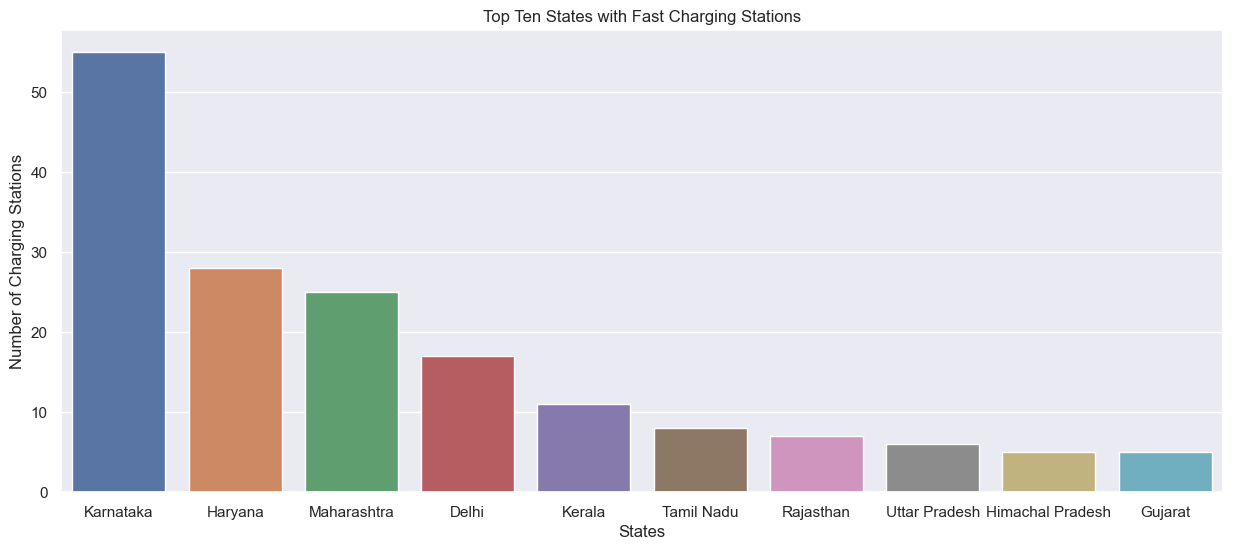

In [19]:
fast_charging = charging_df.query("charging_speed == 'fast'")
top_ten_states_fast = fast_charging["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_fast["index"], y=top_ten_states_fast["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Fast Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

`Karnataka` has the highest number of fast charging stations.

### Cities with fast charging stations

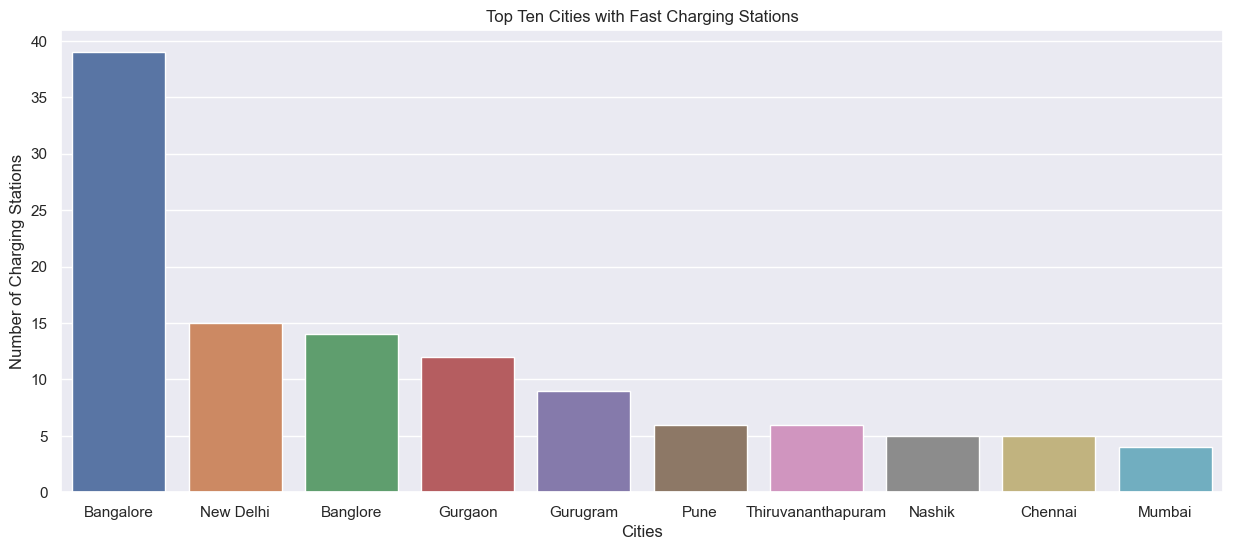

In [20]:
top_ten_cities_fast = fast_charging["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_fast["index"], y=top_ten_cities_fast["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Fast Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

`Bangalore` has the highest number of fast charging stations.

### States with ultra-fast charging stations

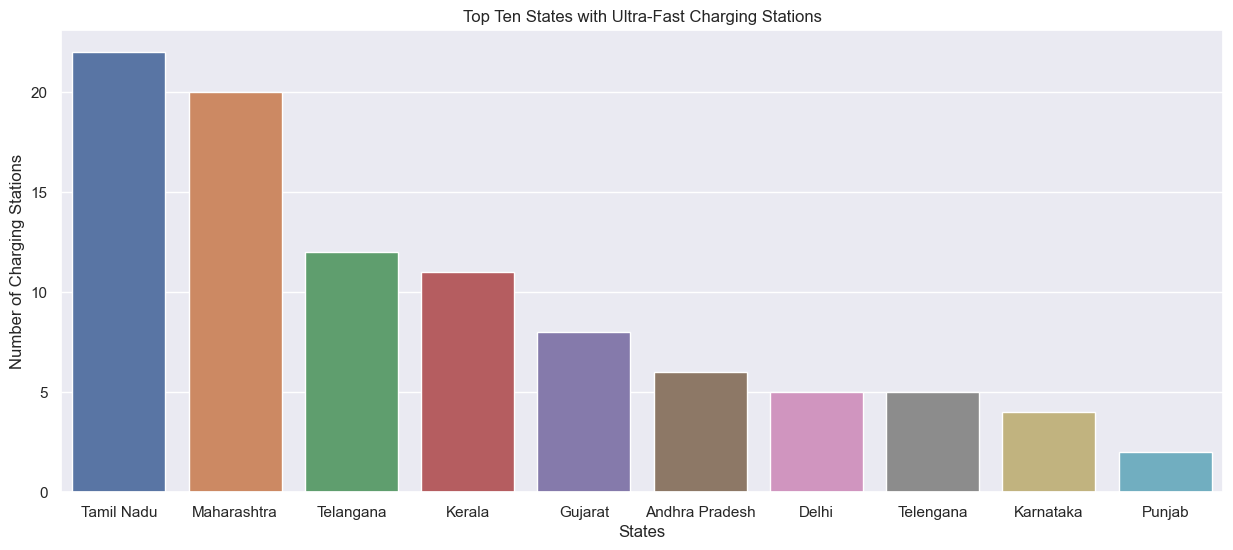

In [21]:
ultra_fast_charging = charging_df.query("charging_speed == 'ultra-fast'")
top_ten_states_ultra_fast = ultra_fast_charging["state"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_states_ultra_fast["index"], y=top_ten_states_ultra_fast["state"])

# Add a title and labels to the axes.
plt.title("Top Ten States with Ultra-Fast Charging Stations")
plt.xlabel("States")
plt.ylabel("Number of Charging Stations");

`Tamil Nadu` and `Maharashtra` has the highest number of ultra-fast charging stations.

### Cities with ultra-fast charging stations

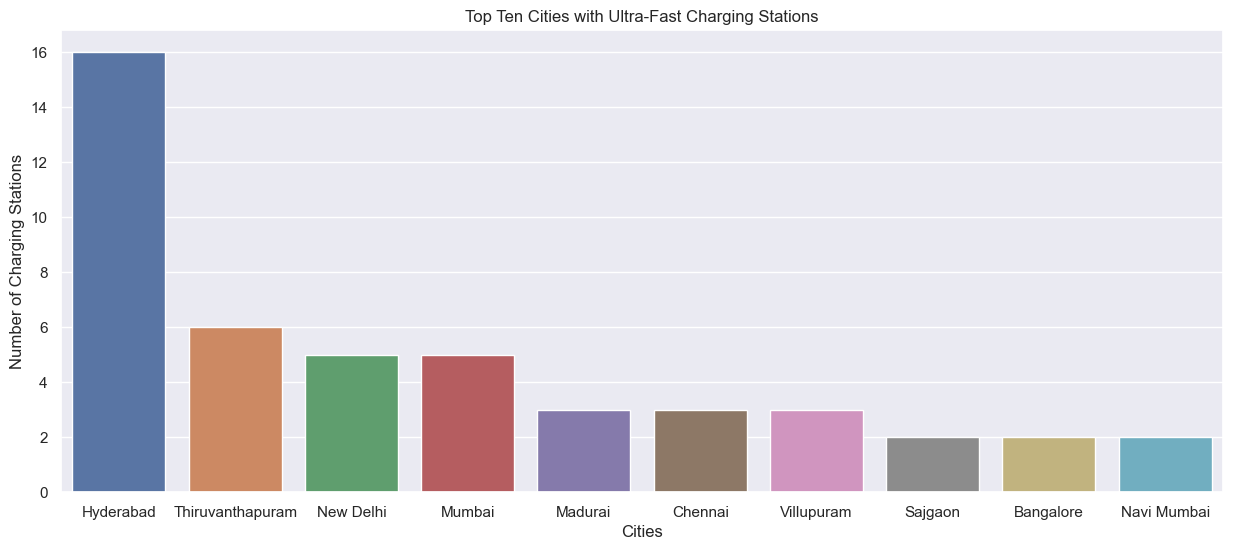

In [22]:
top_ten_cities_ultra_fast = ultra_fast_charging["city"].value_counts().sort_values(ascending=False).reset_index().iloc[:10]

# Create a bar chart.
plt.figure(figsize=(15, 6))
sns.barplot(x=top_ten_cities_ultra_fast["index"], y=top_ten_cities_ultra_fast["city"])

# Add a title and labels to the axes.
plt.title("Top Ten Cities with Ultra-Fast Charging Stations")
plt.xlabel("Cities")
plt.ylabel("Number of Charging Stations");

`Hyderabad` has the highest number of ultra-fast charging stations.

### Locations of charging stations in India

In [26]:
# Create a map of India.
map_india = folium.Map(location=[22.68, 79.04], zoom_start=6)

# Add markers to the map for each charging station.
for i in range(len(charging_df)):
    latitude = charging_df.loc[i, "lattitude"]
    longitude = charging_df.loc[i, "longitude"]
    marker = folium.Marker([latitude, longitude], popup=charging_df.loc[i, "name"])
    marker.add_to(map_india)

# Display the map in Jupyter Notebook.
IPython.display.display(map_india)

The density of charging stations in the southern parts of India is more compared to the nouthern parts.

In [27]:
map_india.save("map_of_charging_stations.html")

## Observations
* The distribution of charging stations in India is uneven, with the majority of stations located in the states of Maharashtra, Delhi, and Tamil Nadu.
* The city with the most number of charging stations is New Delhi, followed by Bangalore and Chennai. These cities are all major metropolitan areas with a high demand for electric vehicles.
* Most of the charging stations in India provide slow charging for EVs, while there are very few ultra-fast charging stations. This is likely due to the high cost of ultra-fast chargers.
* Karnataka has the highest number of fast charging stations in India, followed by Maharashtra and Telangana. Bangalore has the highest number of fast charging stations in India.
* Tamil Nadu and Maharashtra have the highest number of ultra-fast charging stations in India, followed by Telangana and Karnataka. Hyderabad has the highest number of ultra-fast charging stations in India.

These observations suggest that the demand for electric vehicles is highest in the major metropolitan areas of India. The government of India should focus on developing charging infrastructure in these areas to support the growth of the electric vehicle market.

# Analysis of EV Population Data

Dataset Source: https://catalog.data.gov/dataset/electric-vehicle-population-data

The dataset includes the following columns:
* `VIN (1-10)`: The vehicle identification number (VIN) of the electric vehicle.
* `County`: The county where the electric vehicle is registered.
* `City`: The city where the electric vehicle is registered.
* `State`: The state where the electric vehicle is registered.
* `ZIP Code`: The ZIP code where the electric vehicle is registered.
* `Model Year`: The model year of the electric vehicle.
* `Make`: The make of the electric vehicle.
* `Model`: The model of the electric vehicle.
* `Electric Vehicle Type`: The type of electric vehicle, such as battery electric vehicle (BEV) or plug-in hybrid electric vehicle (PHEV).
* `Clean Alternative Fuel Vehicle (CAFV) Eligibility`: Whether the electric vehicle is eligible for Clean Alternative Fuel Vehicle (CAFV) incentives.
* `Electric Range`: The electric range of the electric vehicle in miles.
* `Base MSRP`: The base manufacturer's suggested retail price (MSRP) of the electric vehicle in US dollars.
* `Legislative District`: The legislative district where the electric vehicle is registered.
* `DOL Vehicle ID`: The vehicle identification number assigned by the Department of Licensing (DOL) of the state of Washington.
* `Vehicle Location`: The location of the electric vehicle, represented as a point in geographic coordinates.

## Reading the dataset

In [6]:
# Reading the ev population dataset
population_df = pd.read_csv("datasets/Electric_Vehicle_Population_Data.csv")
population_df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,1N4AZ0CP5D,Kitsap,Bremerton,WA,98310.0,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75,0,23.0,214384901,POINT (-122.61136499999998 47.575195000000065)
1,1N4AZ1CP8K,Kitsap,Port Orchard,WA,98366.0,2019,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,150,0,26.0,271008636,POINT (-122.63926499999997 47.53730000000007)
2,5YJXCAE28L,King,Seattle,WA,98199.0,2020,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,293,0,36.0,8781552,POINT (-122.394185 47.63919500000003)
3,SADHC2S1XK,Thurston,Olympia,WA,98503.0,2019,JAGUAR,I-PACE,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,234,0,2.0,8308492,POINT (-122.8285 47.03646)
4,JN1AZ0CP9B,Snohomish,Everett,WA,98204.0,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,0,21.0,245524527,POINT (-122.24128499999995 47.91088000000008)
